100%|██████████| 1000/1000 [06:55<00:00,  2.41it/s, fitness=0.348]


Best solution length: 203530
Best accuracy on test data: 0.3479999899864197


/opt/homebrew/Caskroom/miniforge/base/envs/mai/lib/python3.12/site-packages/pygad/visualize/plot.py:120: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  matplt.legend()


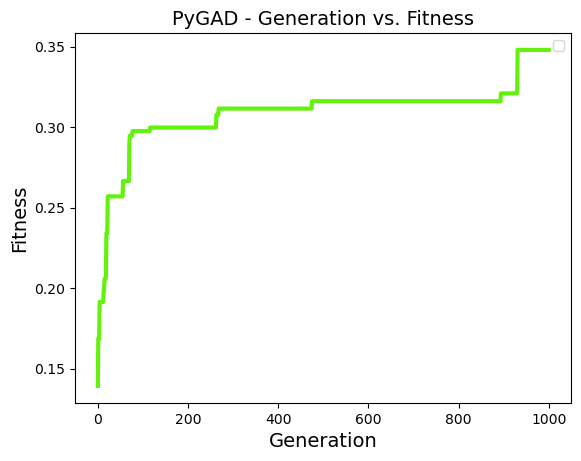

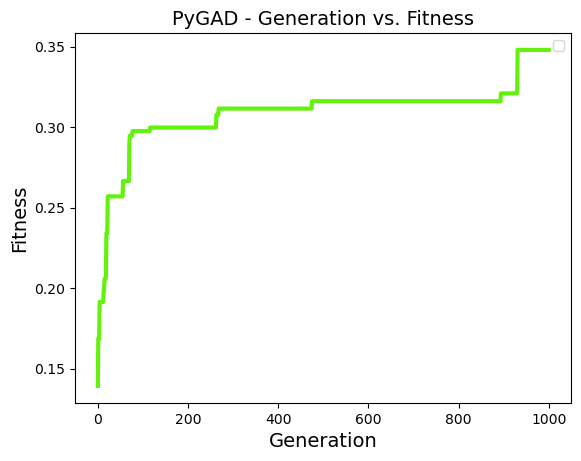

In [3]:
import numpy as np
import pygad
import tqdm
import torch
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

# 1) Fetch MNIST and filter digits 0–4:
mnist = fetch_openml('mnist_784', version=1)
X = mnist.data.values / 255.0
y = mnist.target.values.astype(int)
# mask = y < 5
# X, y = X[mask], y[mask]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device = "cpu"

# Convert to torch tensors (though we'll do manual forward pass here):
X_test_t = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_t = torch.tensor(y_test, dtype=torch.long).to(device)

# 2) Define fixed network dimensions:
input_size = 784
hidden_size = 256
output_size = 10

# Parameter shapes:
# W1: (784, 32), b1: (32,), W2: (32, 5), b2: (5,)
param_count = input_size*hidden_size + hidden_size + hidden_size*output_size + output_size

def forward_pass(solution, X_batch):
    # 3) Parse the solution array into weights/biases:
    start = 0
    end = input_size*hidden_size
    W1 = solution[start:end].reshape((input_size, hidden_size))
    start = end
    end = start + hidden_size
    b1 = solution[start:end]
    start = end
    end = start + hidden_size*output_size
    W2 = solution[start:end].reshape((hidden_size, output_size))
    start = end
    b2 = solution[start:start+output_size]

    # 4) Manual forward pass:
    x_hidden = X_batch @ torch.tensor(W1, dtype=torch.float32).to(device) + torch.tensor(b1, dtype=torch.float32).to(device)
    x_hidden = torch.relu(x_hidden).to(device)
    logits = x_hidden @ torch.tensor(W2, dtype=torch.float32).to(device) + torch.tensor(b2, dtype=torch.float32).to(device)
    return logits

def fitness_func(instance, solution, _):
    # Evaluate accuracy on the test set for simplicity:
    with torch.no_grad():
        logits = forward_pass(solution, X_test_t)
        preds = torch.argmax(logits, dim=1)
        accuracy = (preds == y_test_t).float().mean().item()
    return accuracy  # GA will maximize accuracy


def updateFunction(pbar, instance):
    pbar.update(1)

    #if instance.generations_completed % 10 == 0:
        #print("Generation = {generation}".format(generation=instance.generations_completed))
    fitness = instance.best_solution()[1]
    pbar.set_postfix({"fitness": fitness})
        #print("Fitness    = {fitness}".format(fitness=fitness))
        #print("")
# 5) Create GA instance to optimize NN parameters:


num_generations = 1000
with tqdm.tqdm(total=num_generations) as pbar:
    ga_instance = pygad.GA(
    num_generations=num_generations,
    num_parents_mating=3,
    fitness_func=fitness_func,
    sol_per_pop=5,
    num_genes=param_count,
    gene_space={'low': -1.0, 'high': 1.0},  # allow weights/biases in [-1,1]
    #on_generation=lambda _: pbar.update(1))
    on_generation=lambda instance: updateFunction(pbar, instance))
    ga_instance.run()



best_solution, best_fitness, _ = ga_instance.best_solution()
print("Best solution length:", len(best_solution))
print("Best accuracy on test data:", best_fitness)
ga_instance.plot_fitness()